# Бейзлайн на основе LightAutoML

In [34]:
import numpy as np
import pandas as pd

In [35]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [36]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [37]:
train_data.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [38]:
train_data.replace(
    -1, np.NaN, inplace=True
)  # Судя по описанию данных, -1 означает пропуск в данных. Заменим -1 на более понятный NaN

In [39]:
import seaborn as sns

sns.set(rc={"figure.figsize": (20, 8)})

In [40]:
from sklearn.model_selection import train_test_split

In [41]:
train, val = train_test_split(
    train_data,
    train_size=0.8,
    stratify=train_data.target,  # Стратифицируем для сохранения баланса классов
    random_state=42,
)

print(f"Размер обучающей выборки: {train.shape[0]}")
print(f"Размер валидационной выборки: {val.shape[0]}")

Размер обучающей выборки: 476169
Размер валидационной выборки: 119043


In [42]:
# Разбивка трейна на X и y
X, y = train_data.drop(["target"], axis=1), train_data.target

In [43]:
roles = {
    "target": "target",
    "category": [
        "ps_ind_02_cat",
        "ps_ind_04_cat",
        "ps_ind_05_cat",
        "ps_ind_06_bin",
        "ps_ind_07_bin",
        "ps_ind_08_bin",
        "ps_ind_09_bin",
        "ps_ind_10_bin",
        "ps_ind_11_bin",
        "ps_ind_12_bin",
        "ps_ind_13_bin",
        "ps_calc_20_bin",
        "ps_ind_16_bin",
        "ps_ind_17_bin",
        "ps_ind_18_bin",
        "ps_car_01_cat",
        "ps_car_02_cat",
        "ps_car_03_cat",
        "ps_car_04_cat",
        "ps_car_05_cat",
        "ps_car_06_cat",
        "ps_car_07_cat",
        "ps_car_08_cat",
        "ps_car_09_cat",
        "ps_car_10_cat",
        "ps_car_11_cat",
        "ps_calc_15_bin",
        "ps_calc_16_bin",
        "ps_calc_17_bin",
        "ps_calc_18_bin",
        "ps_calc_19_bin",
    ],
    "drop": ["id"],  # Удаляем id, чтобы не допустить утечек данных
}

In [52]:
# https://stackoverflow.com/questions/46858373/how-to-calculate-normalized-gini-coefficient-in-tensorflow
def gini(y_true, y_pred) -> float:
    # Подсчет gini на основе реальных и предсказанных значений
    assert len(y_true) == len(y_pred)
    all = np.asarray(np.c_[y_true, y_pred, np.arange(len(y_true))], dtype=np.float64)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(y_true) + 1) / 2.0
    return giniSum / len(y_true)


def gini_normalized(y_true, y_pred) -> float:
    # Нормализация gini
    return gini(y_true, y_pred) / gini(y_true, y_pred)

In [45]:
task = Task("binary")
roles = {"target": "target", "drop": ["id"]}

In [46]:
lama = TabularAutoML(
    task=task, cpu_limit=4, timeout=60 * 30, nested_cv_params={"cv": 5}
)

In [47]:
lama.fit_predict(train_data=train_data, roles=roles, verbose=1)

[23:29:50] Stdout logging level is INFO.
[23:29:50] Task: binary

[23:29:50] Start automl preset with listed constraints:
[23:29:50] - time: 1800.00 seconds
[23:29:50] - CPU: 4 cores
[23:29:50] - memory: 16 GB

[23:29:50] Train data shape: (595212, 59)

[23:29:55] Layer 1 train process start. Time left 1794.79 secs
[23:30:17] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[23:30:46] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.6321941629618173
[23:30:46] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[23:30:46] Time left 1744.22 secs

[23:30:53] Selector_LightGBM fitting and predicting completed
[23:31:16] Start fitting Lvl_0_Pipe_1_Mod_0_LightGBM ...
[23:32:03] Fitting Lvl_0_Pipe_1_Mod_0_LightGBM finished. score = 0.631380570631602
[23:32:03] Lvl_0_Pipe_1_Mod_0_LightGBM fitting and predicting completed
[23:32:03] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ... Time budget is 208.71 secs
[23:35:37] Hyperparameters optimization for Lv

array([[0.044881  ],
       [0.03313397],
       [0.02116301],
       ...,
       [0.01731319],
       [0.03080122],
       [0.01907374]], dtype=float32)

In [55]:
predicts = lama.predict(test_data)

In [57]:
pd.DataFrame({"id": test_data.id, "target": predicts.data[:, 0]}).to_csv(
    "submit_lama_v1.csv", index=None
)

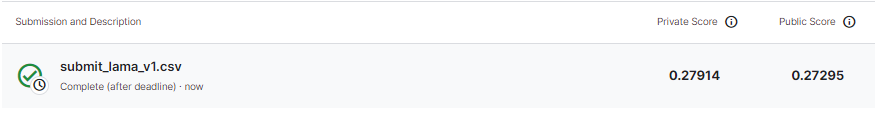